# **The Problem**

Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.



# **The objectives**

Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to :
- Accurately classify a given image from testing dataset into different diseased category or a healthy leaf
- Accurately distinguish between many diseases, sometimes more than one on a single leaf
- Deal with rare classes and novel symptoms

# **Import libraries**

In [1]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
plt.style.use("seaborn-darkgrid")
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

# **Load the data**

In [2]:
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/plant-pathology-2020-fgvc7/test.csv',sep=',')
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/plant-pathology-2020-fgvc7/train.csv',sep=',')
sample=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/plant-pathology-2020-fgvc7/sample_submission.csv',sep=',')

In [3]:
train.head(n=3)

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0

In [4]:
test.head(n=3)

image_id
0   Test_0
1   Test_1
2   Test_2

In [5]:
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (1821, 5)
Test shape :  (1821, 1)


In [6]:
#checking any missing values in the train set
train.isnull().any().sum()

0

In [7]:
#checking any missing values in the test set
train.isnull().any().sum()

0

So we have two data set, the first is for training our model, there is 1821 observations with 4 classes. We need to predict the class of each observation in the test set which has well 1821 observations. 

There isn't any missing values in both of them.

# **Data Analysis**

So we have 1821 observations in the training set where each one belongs to :
- healthy
- rust
- scab
- Multiple diseases

Let see the target's distribution 

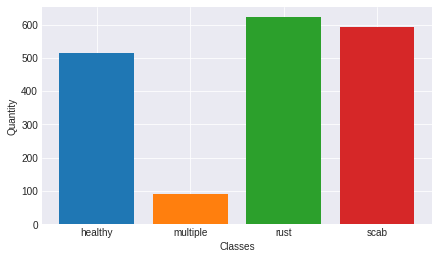

In [8]:
idx={}
c={1:"healthy",2:'multiple',3:'rust',4:'scab'}
d={1:0,2:0,3:0,4:0}
labels=np.array(train.iloc[:,1:])

for i in np.arange(labels.shape[0]):
  for j in np.arange(1,labels.shape[1]+1):
    if labels[i,j-1]==1:
      d[j]+=1
      if j not in idx:
        idx[j]=i

plt.figure(figsize=(7,4))
for key,value in d.items():
  plt.bar(c[key],value)


plt.ylabel('Quantity')
plt.xlabel('Classes')
plt.show()

In [9]:
for i,value in d.items():
  print(c[i]," : ",value)

healthy  :  516
multiple  :  91
rust  :  622
scab  :  592


# **Image visualization**

In [10]:
width=205
heigth=136

In [11]:
image_path='/content/drive/MyDrive/Colab Notebooks/plant-pathology-2020-fgvc7/images/'

In [12]:
#Example of each class

classe=['Healthy','Multiple Diseases','Rust','Scab']
ex_h=plt.imread(os.path.join(image_path,'Train_'+str(idx[1])+'.jpg'))
ex_m=plt.imread(os.path.join(image_path,'Train_'+str(idx[2])+'.jpg'))
ex_r=plt.imread(os.path.join(image_path,'Train_'+str(idx[3])+'.jpg'))
ex_s=plt.imread(os.path.join(image_path,'Train_'+str(idx[4])+'.jpg'))

Image=np.array([ex_h,ex_m,ex_r,ex_s])

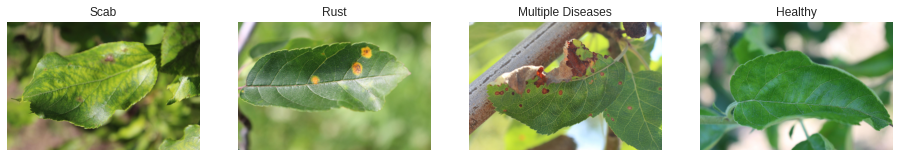

In [13]:
fig=plt.figure(figsize=(20, 16))
for i in range(1, 5):
    plt.subplot(550+i+1)
    plt.title(classe[-i])
    plt.imshow(Image[-i,:,:,:])
    plt.grid(False)
    plt.axis('off')
plt.show()

# **Chanel distribution**

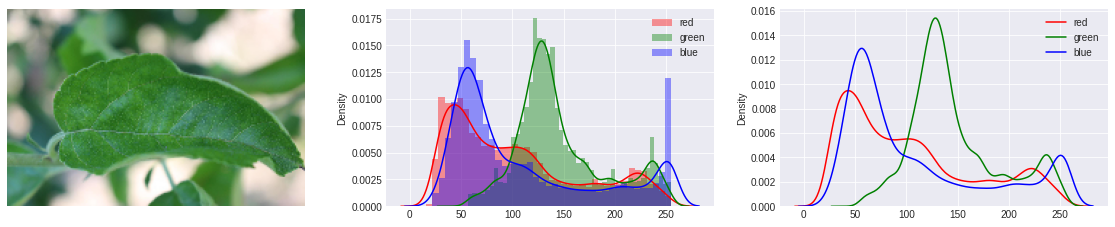

In [14]:
# An example for one image 

img=cv2.cvtColor(ex_h,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(width,heigth))

plt.figure(figsize=(20,8))
plt.subplot(231)
plt.imshow(cv2.resize(ex_h,(width,heigth)))
plt.grid(False)
plt.axis('off')
plt.subplot(232)
sns.distplot( img[:,:,0] , color="red", label="red")
sns.distplot( img[:,:,1] , color="green", label="green")
sns.distplot( img[:,:,2] , color="blue", label="blue")
plt.legend()
plt.subplot(233)
sns.distplot( img[:,:,0] , color="red", label="red",hist=False)
sns.distplot( img[:,:,1] , color="green", label="green",hist=False)
sns.distplot( img[:,:,2] , color="blue", label="blue",hist=False)
plt.legend()

Now we are going to see how it looks like for each class and then we'll compare them per pixel's type.

First we need to dowload every image per class.


In [15]:
def pixel_distribution(data):

  red=[np.mean(data[i][:,:,0]) for i in np.arange(data.shape[0])]
  green=[np.mean(data[i][:,:,1]) for i in np.arange(data.shape[0])]
  blue=[np.mean(data[i][:,:,2]) for i in np.arange(data.shape[0])]

  plt.figure(figsize=(8,4))
  sns.distplot(red, color="red", label="red")
  sns.distplot(green, color="green", label="green")
  sns.distplot(blue, color="blue", label="blue")
  plt.legend()
  


In [ ]:
# Image download
X_train={}
train_index=train['image_id']
i=0

for path in train_index:
  p='/'+str(path)+'.jpg'
  image=cv2.imread(image_path+p)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(width,heigth))
  X_train[path]=image
  i+=1
  print(i)



In [17]:
#Index for each class
healthy_index=train['image_id'].loc[train['healthy']==1]
rust_index=train['image_id'].loc[train['rust']==1]
multiple_index=train['image_id'].loc[train['multiple_diseases']==1]
scab_index=train['image_id'].loc[train['scab']==1]

### **Helthy images**

In [18]:
healthy_image=[]
for id in healthy_index:
  healthy_image.append(X_train.get(id))

In [19]:
healthy_image=np.array(healthy_image)

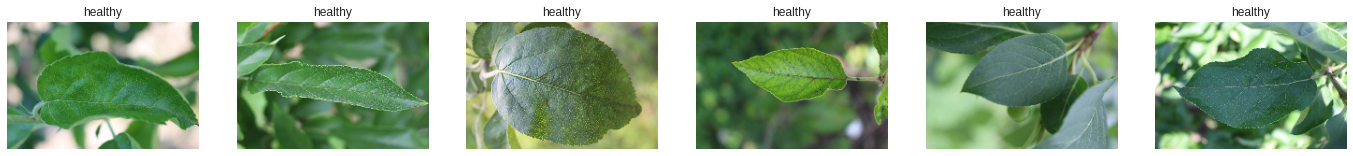

In [20]:
#Several example of healthy images
plt.figure(figsize=(24,24))

for i in np.arange(6):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(healthy_image[i])
  plt.title('healthy')

plt.show()


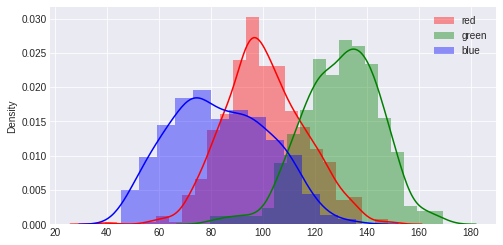

In [21]:
#Pixel distribution of the healthy class
pixel_distribution(healthy_image)

### **Multiple diseases**

In [22]:
multiple_image=[]
for id in multiple_index:
  multiple_image.append(X_train.get(id))

In [23]:
multiple_image=np.array(multiple_image)

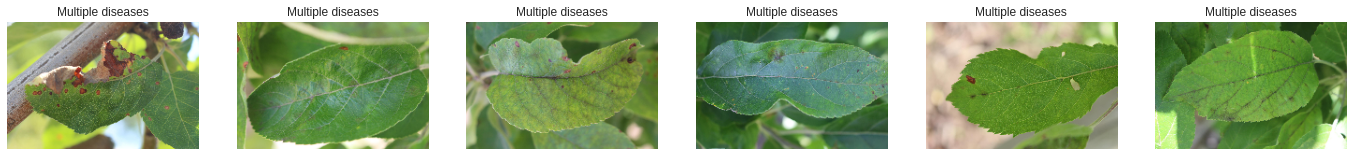

In [24]:
#Several example of muliples diseases images
plt.figure(figsize=(24,24))

for i in np.arange(6):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(multiple_image[i])
  plt.title('Multiple diseases')

plt.show()

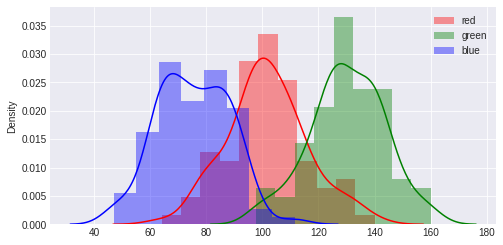

In [25]:
#Pixel distribution for the multiple diseases class
pixel_distribution(multiple_image)

### **Rust**

In [26]:
rust_image=[]
for id in rust_index:
  rust_image.append(X_train.get(id))

In [27]:
rust_image=np.array(rust_image)

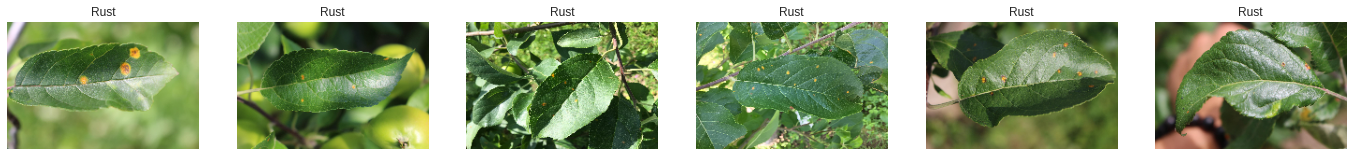

In [28]:
# Several examples of rust

plt.figure(figsize=(24,24))

for i in np.arange(6):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(rust_image[i])
  plt.title('Rust')

plt.show()


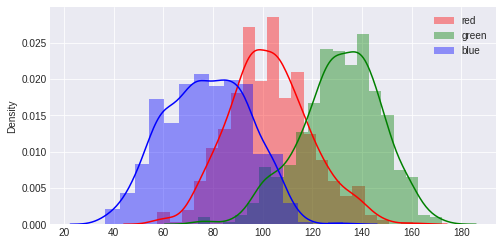

In [29]:
#Pixel distribution for the rust class
pixel_distribution(rust_image)

### **Scab**

In [30]:
scab_image=[]
for id in scab_index:
  scab_image.append(X_train.get(id))

In [31]:
scab_image=np.array(scab_image)

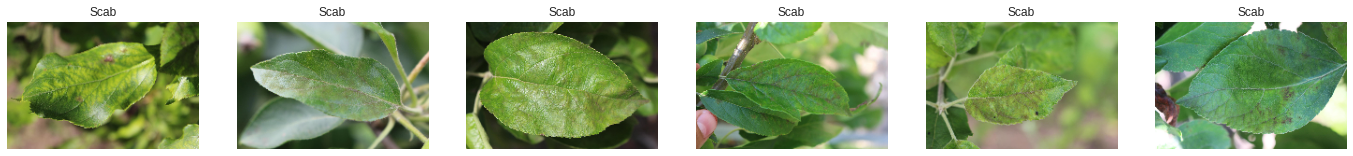

In [32]:
#Several examples of rust
plt.figure(figsize=(24,24))

for i in np.arange(6):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(scab_image[i])
  plt.title('Scab')

plt.show()

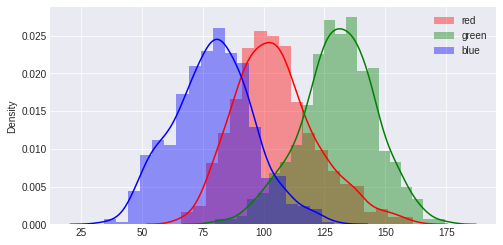

In [33]:
#Pixel distribution for the scab class
pixel_distribution(scab_image)

Now we can compare the distribution of the red, green and blue pixel per class. We'll see which pixel's variations can be a good sign for having a particular disease. We are going to compare many times this distribution when we'll use different data transformation so we need a function which we can easily use.

In [34]:
sorted_data={"Healtly":healthy_image,"Multiple disease":multiple_image,"Rust":rust_image,"Scab":scab_image}

In [35]:
Channel={'red':0,"green":1,'blue':2}
label=[train.columns[i] for i in np.arange(1,5)]
colorChannel={'red':['red','orange','maroon','darkred'],
              'green':['darkgreen','seagreen','lightgreen','olive'],
              'blue':['royalblue','blue','navy','skyblue']}



def Channel_comparaison(channel):
  d=pd.DataFrame(columns=['pixel','type'])
  plt.figure(figsize=(8,3))
  for (key,c,col) in zip(sorted_data.keys(),sorted_data.values(),colorChannel[channel]):
    pixel=[np.mean(img[:,:,Channel[channel]]) for img in c]
    sns.kdeplot(pixel,label=key,color=col,shade=True)
    plt.legend(loc='best')
    plt.title('Distribution of the '+channel+' pixel in each class')



(None, None, None)

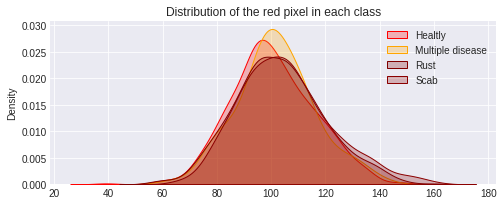

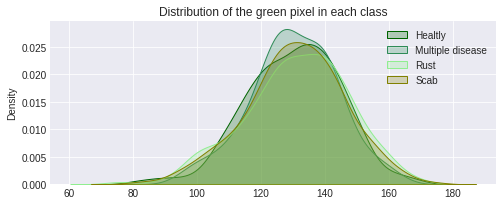

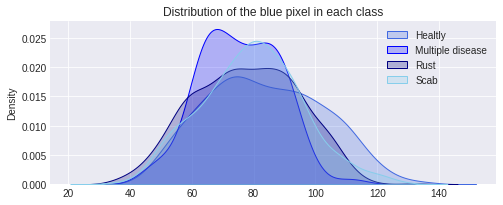

In [36]:
Channel_comparaison('red'),Channel_comparaison('green'),Channel_comparaison("blue")

For the red and green channel the distributions are quite similar. But for the blue channel they are quite different. The key for well classifie our images might be the blue channel.


# **Data augmentation and transformation**

In [37]:
from keras.preprocessing.image import array_to_img

In [38]:
# Train set like an array
IMAGE = list(X_train.values())
IMAGE = np.array(IMAGE)/255.0


In [39]:
def filter_visualization(data,function):
  fig,ax=plt.subplots(figsize=(9,6),nrows=3,ncols=2)
  for i in np.arange(3):
    original=data[np.random.randint(100)]
    transform=function(original)
    ax[i,0].imshow(original)
    ax[i,0].set_title('Original')
    ax[i,0].axis('off')
    ax[i,1].imshow(transform)
    ax[i,1].set_title('Transform')
    ax[i,1].axis('off')


### Gray convertion

In digital photography, computer-generated imagery, and colorimetry, a grayscale or image is one in which the value of each pixel is a single sample representing only an amount of light. So each pixel is a linear transformation of the red, green and blue pixel. 

In [40]:
def gray(img):
  img2=cv2.cvtColor(np.float32(img),cv2.COLOR_RGB2GRAY)
  return img2

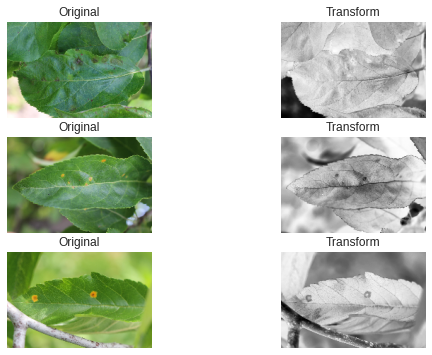

In [41]:
filter_visualization(IMAGE,gray)

### YCrCb filter convertion

In [42]:
def YCR(img):
  img2=cv2.cvtColor(np.float32(img),cv2.COLOR_RGB2YCrCb)
  return img2



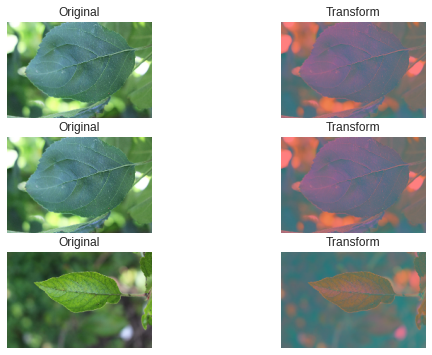

In [43]:
filter_visualization(IMAGE,YCR)

### YUV conversion

YUV is a color encoding system typically used as part of a color image pipeline. It encodes a color image or video taking human perception into account, allowing reduced bandwidth for chrominance components

In [44]:
def yuv(img):
  img2=cv2.cvtColor(np.float32(img),cv2.COLOR_RGB2YUV)
  return img2


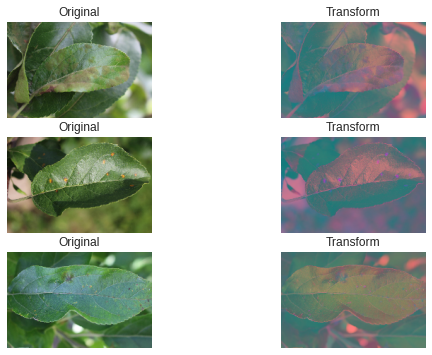

In [45]:
filter_visualization(IMAGE,yuv)

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

First we create a function which can be used for visualizing the transformation which we are going to do with ImageDataGenerator. We are going to use several filters and see what is going on our images.

In [47]:
#Data generator definition
dataGen = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=.1,
                               fill_mode='nearest',
                               shear_range=0.1,
                               rescale=1/255,
                               brightness_range=[0.5, 1.5])

In [48]:
def DataGenerator_VISU(data,generator,visu=True):

  new_set=generator.flow(data,batch_size=36)
  k=np.random.randint(20)
  plt.figure(figsize=(10,10))
  for i in np.arange(15):
    plt.subplot(5,5,i+1)
    plt.imshow(new_set[0][k])
    plt.axis('off')

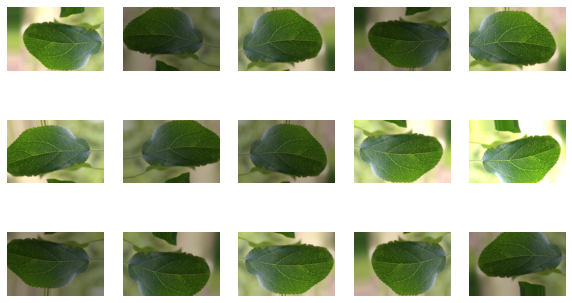

In [49]:
# exemple
DataGenerator_VISU(data=IMAGE,generator=dataGen)

# **Modeling with DenseNet**

In [50]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Input
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121

In [51]:
def performance_visualization(hist):
  fig,ax=plt.subplots(figsize=(20,5),nrows=1,ncols=2)
  ax[0].plot(hist.history['loss'])
  ax[0].plot(hist.history['val_loss'])
  ax[0].set_title('model loss')
  ax[0].set_ylabel('loss')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train','val'],loc='best')

  ax[1].plot(hist.history['categorical_accuracy'])
  ax[1].plot(hist.history['val_categorical_accuracy'])
  ax[1].set_title('model accuracy')
  ax[1].set_ylabel('accuracy')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train','val'],loc='best')




In [52]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(136, 205, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(4,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    model.summary()
    
    return model

### **Model training without image filter**




In [53]:
def display_image(data):
  plt.figure(figsize=(24,24))
  for i in np.arange(6):
    k=np.random.randint(100)
    plt.subplot(6,6,i+1)
    plt.imshow(data[k])
    plt.axis('off')


In [54]:
x_train,x_val,y_train,y_val=train_test_split(IMAGE,labels,test_size=0.2)

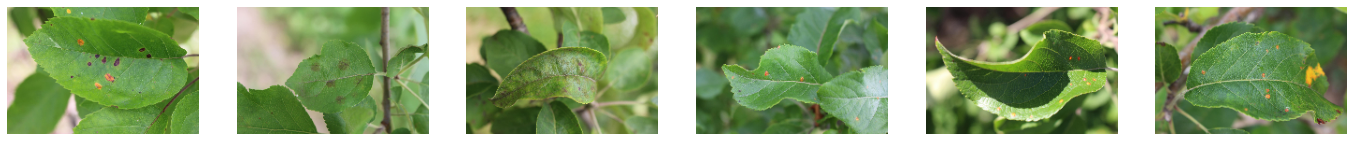

In [55]:
# Example of images in the training set
display_image(x_train)

In [56]:
modelA=build_densenet()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 136, 205, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 136, 205, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

In [57]:
history_modelA=modelA.fit_generator(dataGen.flow(x_train,y_train,batch_size=32),
                                   steps_per_epoch=x_train.shape[0]/32,
                                   epochs=50,
                                   verbose=2,
                                   validation_data=(x_val,y_val))

Epoch 1/50
45/45 - 27s - loss: 2.2828 - categorical_accuracy: 0.2898 - val_loss: 1.4411 - val_categorical_accuracy: 0.2822
Epoch 2/50
45/45 - 12s - loss: 1.5147 - categorical_accuracy: 0.4677 - val_loss: 1.4554 - val_categorical_accuracy: 0.3945
Epoch 3/50
45/45 - 12s - loss: 0.9849 - categorical_accuracy: 0.6827 - val_loss: 1.2066 - val_categorical_accuracy: 0.6164
Epoch 4/50
45/45 - 12s - loss: 0.6779 - categorical_accuracy: 0.8001 - val_loss: 1.8615 - val_categorical_accuracy: 0.6055
Epoch 5/50
45/45 - 12s - loss: 0.5656 - categorical_accuracy: 0.8407 - val_loss: 0.7952 - val_categorical_accuracy: 0.7753
Epoch 6/50
45/45 - 12s - loss: 0.4961 - categorical_accuracy: 0.8544 - val_loss: 0.8705 - val_categorical_accuracy: 0.7890
Epoch 7/50
45/45 - 12s - loss: 0.4511 - categorical_accuracy: 0.8640 - val_loss: 0.7084 - val_categorical_accuracy: 0.8027
Epoch 8/50
45/45 - 12s - loss: 0.3731 - categorical_accuracy: 0.8812 - val_loss: 1.2413 - val_categorical_accuracy: 0.7452
Epoch 9/50
45/45

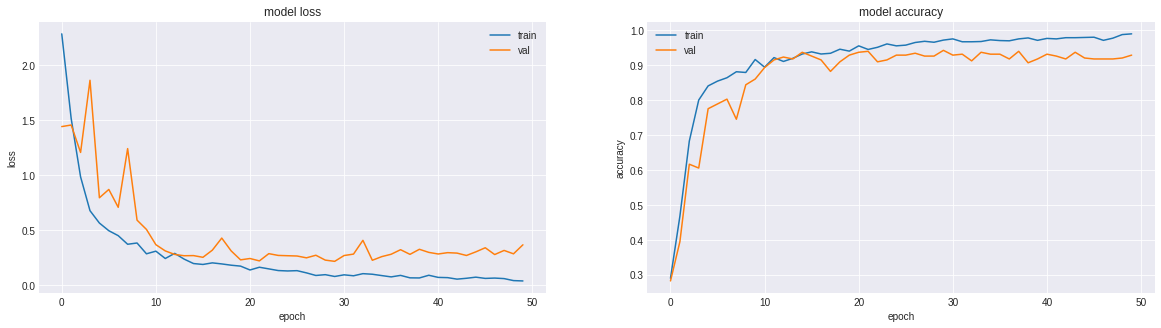

In [58]:
performance_visualization(history_modelA)

### **Model training with YCR filter**

In [59]:
ycr_Image=np.array([YCR(IMAGE[i]) for i in np.arange(IMAGE.shape[0])])

In [60]:
x_train,x_val,y_train,y_val=train_test_split(ycr_Image,labels,test_size=0.2)

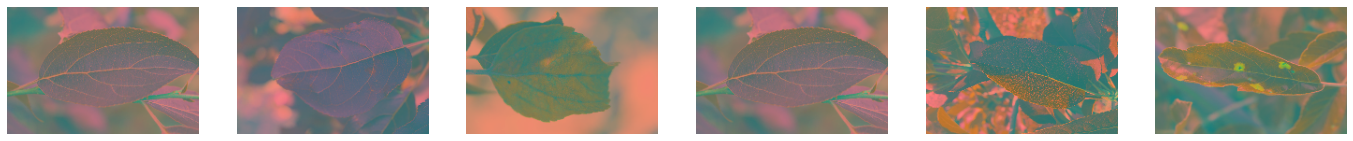

In [61]:
#Example of images in the training set
display_image(x_train)

In [62]:
modelB=build_densenet()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 136, 205, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 205, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

In [ ]:
history_modelB=modelB.fit_generator(dataGen.flow(x_train,y_train,batch_size=32),
                                   steps_per_epoch=x_train.shape[0]/32,
                                   epochs=50,
                                   verbose=2,
                                   validation_data=(x_val,y_val))

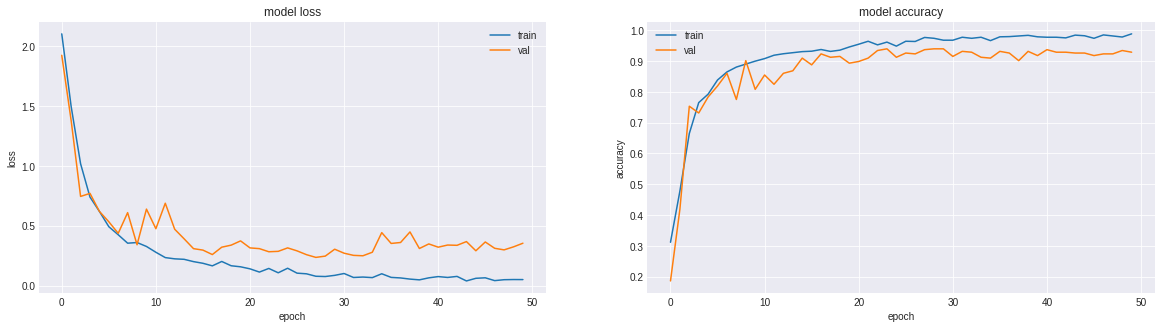

In [64]:
performance_visualization(history_modelB)

### **Model training with YUV filter**

In [65]:
YUV_Image=np.array([yuv(IMAGE[i]) for i in np.arange(IMAGE.shape[0])])

In [66]:
x_train,x_val,y_train,y_val=train_test_split(YUV_Image,labels,test_size=0.2)

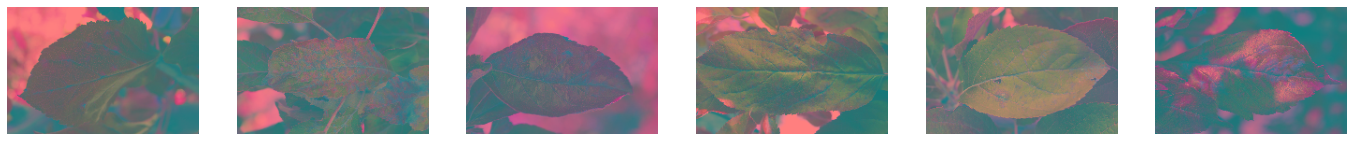

In [67]:
display_image(x_val)

In [68]:
modelC=build_densenet()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 136, 205, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 136, 205, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2624

In [ ]:
history_modelC=modelC.fit_generator(dataGen.flow(x_train,y_train,batch_size=32),
                                   steps_per_epoch=x_train.shape[0]/32,
                                   epochs=50,
                                   verbose=2,
                                   validation_data=(x_val,y_val))

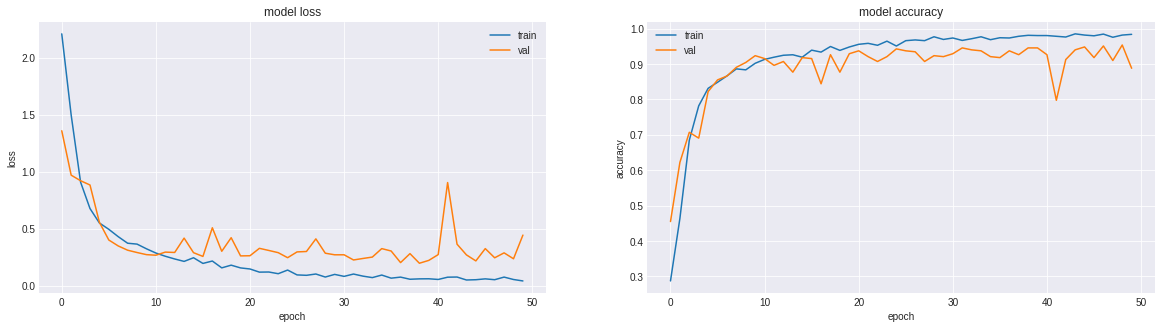

In [70]:
performance_visualization(history_modelC)

# **Conclusion and submission**

The best model seems to be DenseNet without image transformation, we can have an accuracy of 0.94 but the others models with image transformation can allow us to have great scores too. A good idea for the future could be to use ensembling methods. 



Here the submission with the first modelA.

In [ ]:
X_test={}
test_index=test['image_id']
i=0

for path in test_index:
  p='/'+str(path)+'.jpg'
  image=cv2.imread(image_path+p)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(width,heigth))
  X_test[path]=image
  i+=1
  print(i)


In [72]:
Image_test = list(X_test.values())
Image_test = np.array(Image_test)/255.0

In [73]:
# ModelA prediction
pred=modelA.predict(Image_test)

sample.loc[:, 'healthy':] = pred
sample.head()

image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.000001       6.893816e-05  9.999298e-01  1.387196e-07
1   Test_1  0.000002       8.001564e-06  9.999902e-01  1.348738e-07
2   Test_2  0.000007       7.594894e-04  4.654442e-07  9.992325e-01
3   Test_3  1.000000       1.266305e-07  2.419754e-09  5.594413e-09
4   Test_4  0.000550       5.147753e-02  9.478825e-01  9.033299e-05

In [74]:
sample.iloc[2,1:]

healthy              7.49041e-06
multiple_diseases    0.000759489
rust                 4.65444e-07
scab                    0.999233
Name: 2, dtype: object

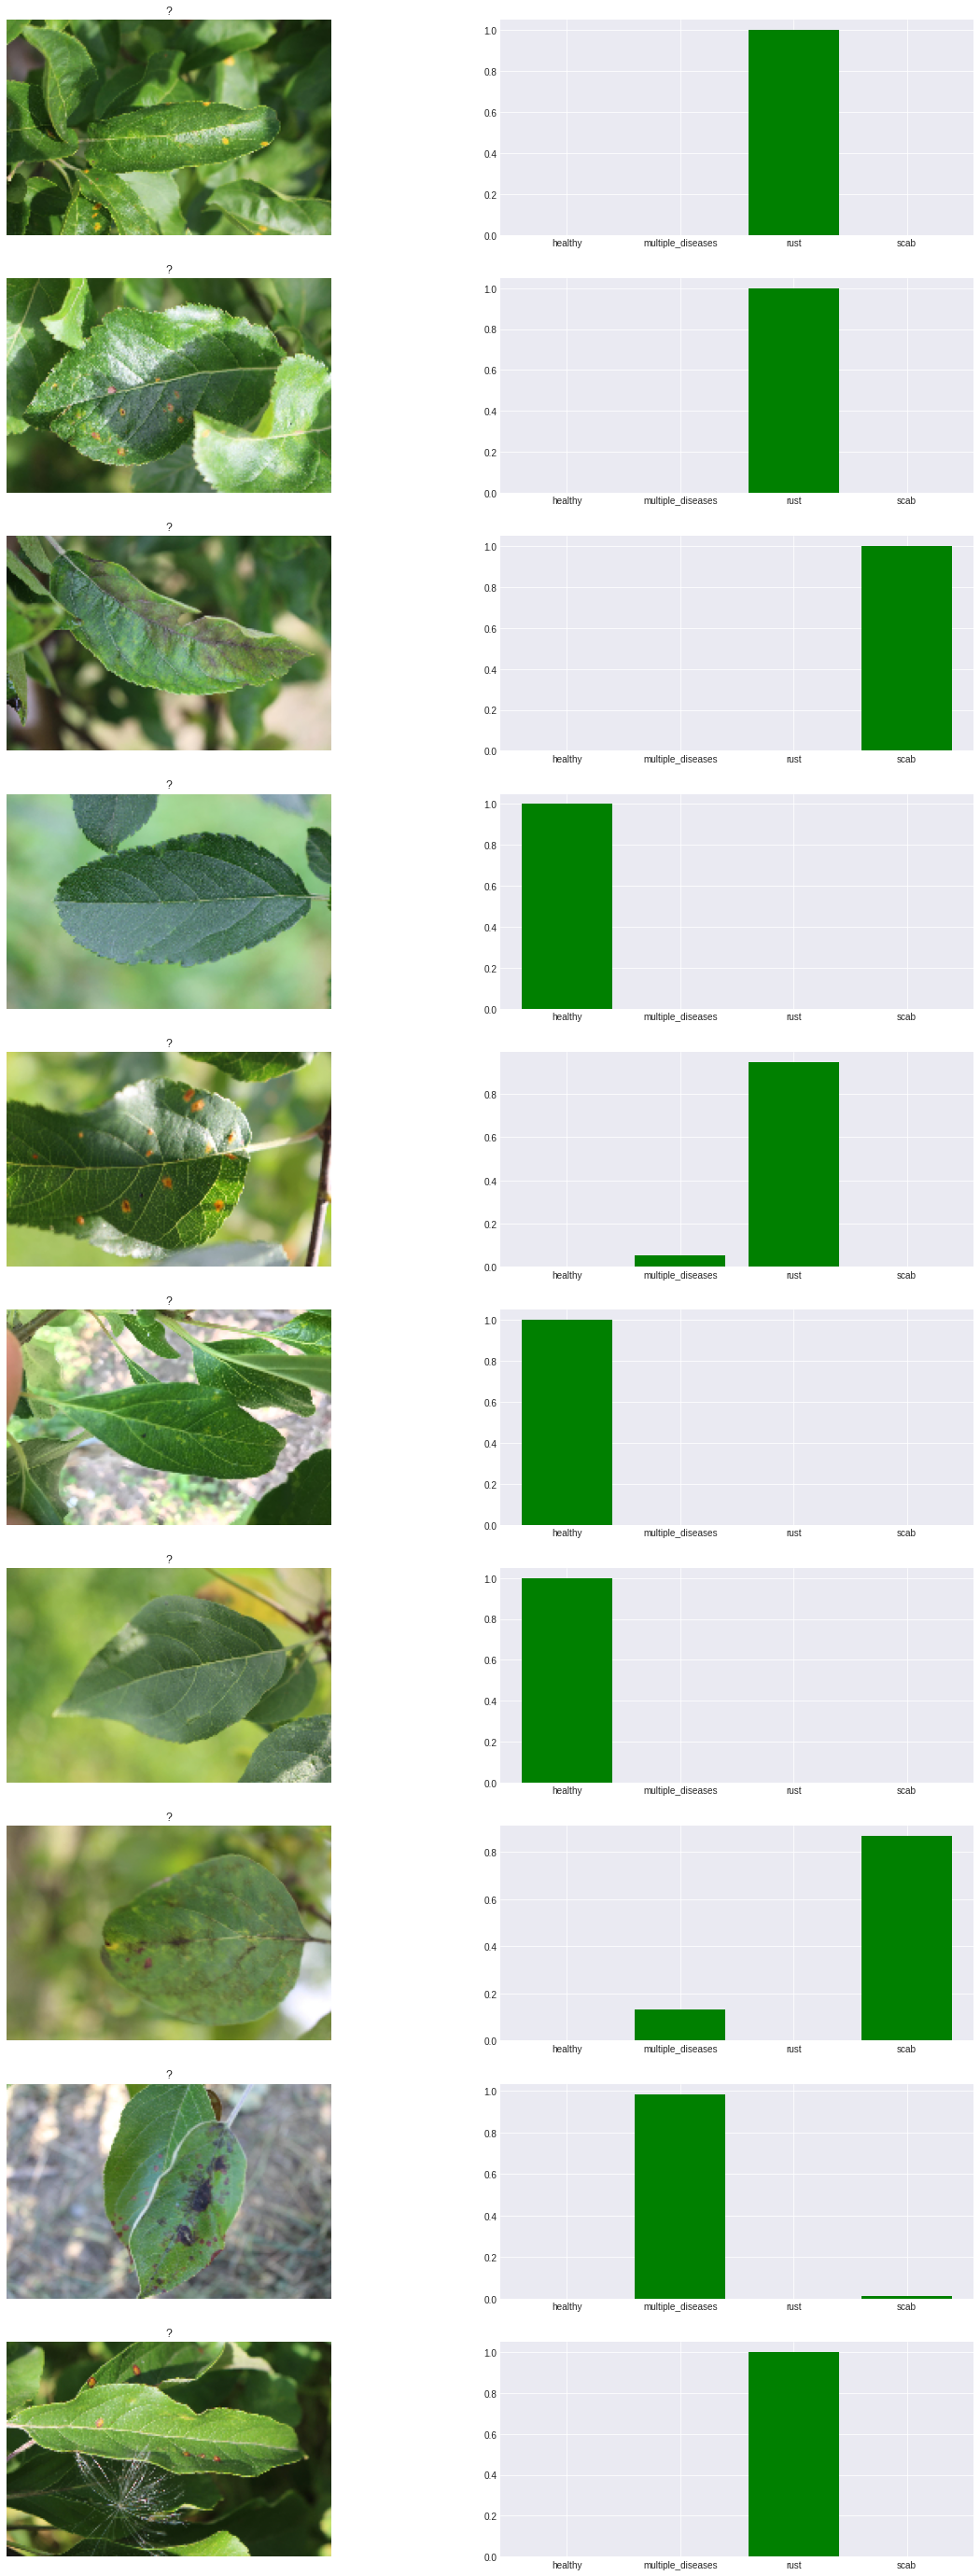

In [75]:
fig,ax=plt.subplots(figsize=(20,50),nrows=10,ncols=2)

for i in np.arange(10):
  ax[i,0].set_xticks([])
  ax[i,0].set_yticks([])
  ax[i,0].grid(False)
  ax[i,0].imshow(Image_test[i])
  ax[i,0].set_title('?')

  ax[i,1].bar(x=sample.columns[1:],height=sample.iloc[i,1:],color='green',linewidth=0.1)
  ax[i,0].grid(True)